In [137]:
from market_data_loader import MarketDataLoader
from order import Order
from order import risk_params
from oms import OrderManagementSystem
from order_book import LimitOrderBook
from position_tracker import PositionTracker
from strategies.trend_following   import run_backtest as tf_backtest
from strategies.mean_reversion    import run_backtest as mr_backtest
from strategies.arbitrage         import run_backtest as arb_backtest
import uuid

loader  = MarketDataLoader(interval="5m", period="1mo")
oms     = OrderManagementSystem()
tracker = PositionTracker()
book    = LimitOrderBook("AAPL")

rp = risk_params()

In [149]:
signals, trades, metrics = tf_backtest("AAPL", loader, risk_params, short_win=10, long_win=50)

[*********************100%***********************]  1 of 1 completed


In [165]:
"""
Remember, our trades need a counter-order, even in the tracker. So we have to make them up again here. 
"""
trades_list = []

for trade in trades:
    #Real order
    order = Order(
        id=f"REPLAY-{trade['order_id']}",
        symbol=trade["symbol"],
        side=trade["side"],
        quantity=trade["filled_qty"],
        type="market",  # or "limit" if needed
        price=trade["price"],
        timestamp=trade["timestamp"]
    )

    counter_order = Order(
        id=f"FAKE-{trade['order_id']}",
        symbol=trade["symbol"],
        side="buy" if trade["side"] == "sell" else "sell",
        quantity=trade["filled_qty"],
        type="limit",
        price=trade["price"],
        timestamp=trade["timestamp"]
    )

    book.add_order(counter_order)

    oms.new_order(order)
    exec_reports = book.add_order(order)

    for rpt in exec_reports:
        if str(rpt["order_id"]).startswith("FAKE"):
            continue
        tracker.update(rpt)
        trades_list.append(rpt.copy())


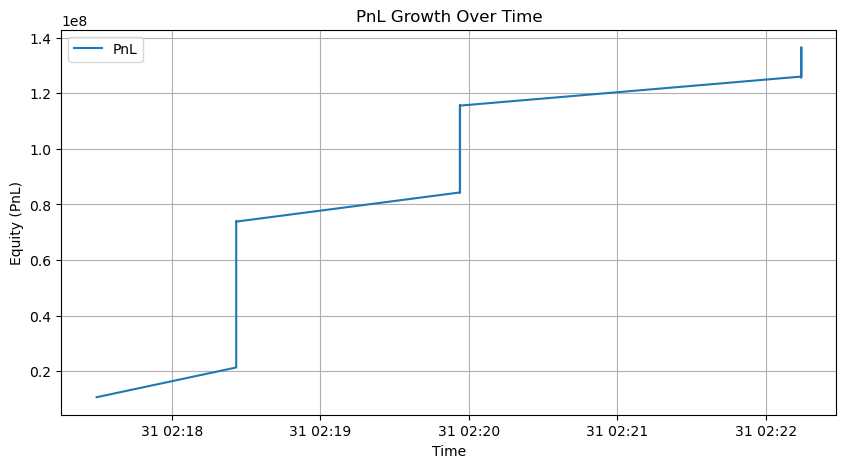

                   timestamp symbol  side  quantity       price     cash_flow
0 2025-07-31 02:17:29.590218   AAPL  sell     50000  214.274994  1.071375e+07
1 2025-07-31 02:18:25.977495   AAPL  sell     50000  213.759995  1.068800e+07
2 2025-07-31 02:18:25.977649   AAPL  sell     50000  212.559998  1.062800e+07
3 2025-07-31 02:18:25.977771   AAPL  sell     50000  210.839996  1.054200e+07
4 2025-07-31 02:18:25.977799   AAPL   buy     50000  211.589996 -1.057950e+07


In [180]:
import pandas as pd
import matplotlib.pyplot as plt

blotter_df = tracker.get_blotter()
blotter_df["timestamp"] = pd.to_datetime(blotter_df["timestamp"])
blotter_df = blotter_df.sort_values("timestamp")
starting_cash = tracker.cash - blotter_df["cash_flow"].sum()
blotter_df["equity"] = blotter_df["cash_flow"].cumsum() + starting_cash

# Plot
plt.figure(figsize=(10, 5))
plt.plot(blotter_df["timestamp"], blotter_df["equity"], label="PnL")
plt.xlabel("Time")
plt.ylabel("Equity (PnL)")
plt.title("PnL Growth Over Time")
plt.legend()
plt.grid(True)
plt.show()

print(blotter.head())

#? Broken??? Blotter doesn't contain pnl
#blotter["cum_pnl"] = blotter["pnl"].cumsum()
#blotter.set_index("timestamp")["cum_pnl"].plot(figsize=(10,5), title="Equity Curve")

In [182]:
print(f"**Total Return:**  {metrics["total_return"]:.2%}")  
print(f"**Max Drawdown:**  {metrics["max_drawdown"]:.2%}")  
print(f"**Sharpe Ratio:**  {metrics["sharpe_ratio"]:.2f}")
print("Find github repo at: https://github.com/wyhar1/HW5Finm25000/")

**Total Return:**  13.53%
**Max Drawdown:**  -1098789367.68%
**Sharpe Ratio:**  0.32
Find github repo at: https://github.com/wyhar1/HW5Finm25000/
